In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
sn.set_style("whitegrid")
import sympy as sym

import pycollocation
import pyam

In [7]:
# should be 0.4.0a0
pycollocation.__version__

'0.4.0a0'

In [8]:
# should be 0.2.0a0
pyam.__version__

'0.2.0a0'

## Defining inputs

Need to define some heterogenous factors of production...

In [39]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': 1e0, 'mu1': 0.0, 'sigma1': 1.0}

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=(1.2, 1e1),  # guesses for the alpha and (1 - alpha) quantiles!
                     alpha=0.005,
                     measure=15.0  # 15x more workers than firms
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 1e0, 'mu2': 0.0, 'sigma2': 1.0}

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=(1.2, 1e1),  # guesses for the alpha and (1 - alpha) quantiles!
                   alpha=0.005,
                   measure=1.0
                   )

Note that we are shifting the distributions of worker skill and firm productivity to the right by 1.0 in order to try and avoid issues with having workers (firms) with near zero skill (productivity).

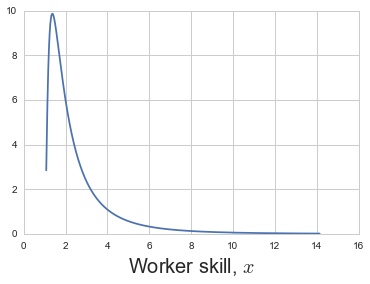

In [40]:
xs = np.linspace(workers.lower, workers.upper, 1e4)
plt.plot(xs, workers.evaluate_pdf(xs))
plt.xlabel('Worker skill, $x$', fontsize=20)
plt.show()

## Defining a production process

Next need to define some production process...

In [41]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)
F = A * B

In [42]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.0 }

## Define a boundary value problem

In [43]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=F,
                                          F_params=F_params)

## Pick some collocation solver

In [44]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess
Currently I guess that $\mu(x)$ is has the form...

$$ \hat{\mu}(x) = \beta_0 + \beta_1 f(x) $$

(i.e., a linear translation) of some function $f$.  Using my $\hat{\mu}(x)$, I can then back out a guess for $\theta(x)$ implied by the model...

$$ \hat{\theta}(x) = \frac{H(x)}{\hat{\mu}'(x)} $$

In [51]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 75, 'theta': 75},
                                                    f=lambda x, alpha: x**alpha,
                                                    alpha=0.25)

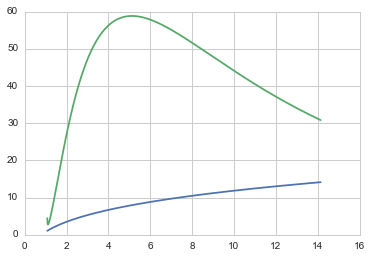

In [52]:
# quickly plot the initial conditions
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [53]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [54]:
solver.result.success

True

## Plot some results

In [55]:
viz = pyam.Visualizer(solver)

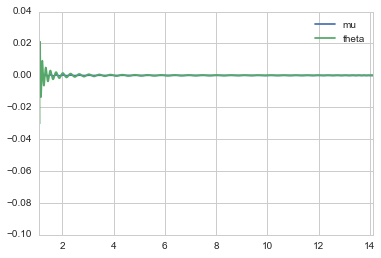

In [56]:
viz.interpolation_knots = np.linspace(workers.lower, workers.upper, 1000)
viz.residuals.plot()
plt.show()

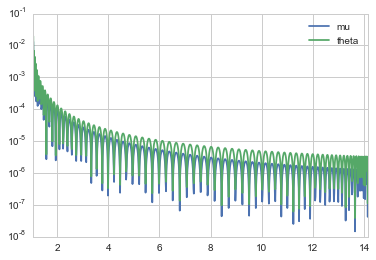

In [57]:
viz.normalized_residuals[['mu', 'theta']].plot(logy=True)
plt.show()

In [58]:
viz.solution.tail()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
14.089895,80.393180,1.239461,0.619731,40.196590,1.429173,0.022034,0.714586,0.151663,4.265630,0.065765,2.132815,1.239461,40.196590,14.125999,32.430700
14.102974,80.427887,1.240037,0.620019,40.213944,1.427779,0.022013,0.713889,0.151495,4.266927,0.065787,2.133463,1.240037,40.213944,14.130067,32.429627
14.116053,80.462524,1.240613,0.620306,40.231262,1.426386,0.021993,0.713193,0.151328,4.268222,0.065810,2.134111,1.240613,40.231262,14.134125,32.428541
14.129132,80.497089,1.241188,0.620594,40.248544,1.424994,0.021972,0.712497,0.151162,4.269516,0.065832,2.134758,1.241188,40.248544,14.138173,32.427442
14.142212,80.531577,1.241762,0.620881,40.265788,1.423603,0.021951,0.711801,0.150995,4.270809,0.065854,2.135404,1.241762,40.265788,14.142212,32.426326


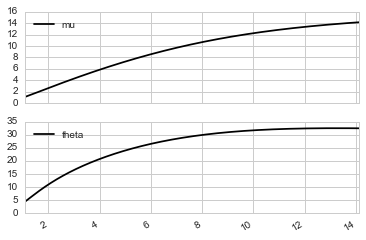

In [59]:
viz.solution[['mu', 'theta']].plot(subplots=True)
plt.show()

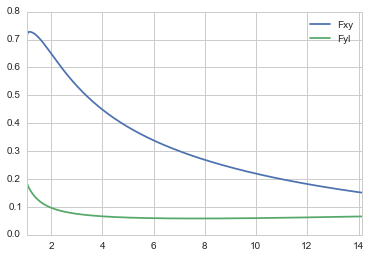

In [60]:
viz.solution[['Fxy', 'Fyl']].plot()
plt.show()

## Plot factor payments
Note the `factor_payment_1` is wages and `factor_payment_2` is profits...

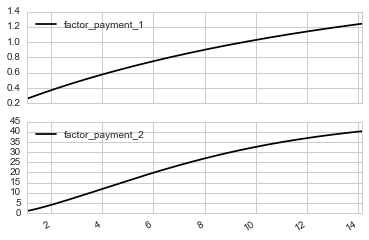

In [61]:
viz.solution[['factor_payment_1', 'factor_payment_2']].plot(subplots=True)
plt.show()

## Plot firm size against wages and profits

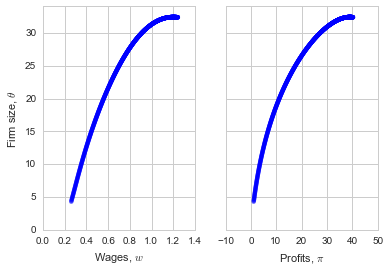

In [62]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].scatter(viz.solution.factor_payment_1, viz.solution.theta, alpha=0.5,
               edgecolor='none')
axes[0].set_ylim(0, 1.05 * viz.solution.theta.max())
axes[0].set_xlabel('Wages, $w$')
axes[0].set_ylabel(r'Firm size, $\theta$')

axes[1].scatter(viz.solution.factor_payment_2, viz.solution.theta, alpha=0.5,
               edgecolor='none')
axes[1].set_xlabel(r'Profits, $\pi$')

plt.show()

In [63]:
# to get correlation just use pandas!
viz.solution.corr()

,F,Fl,Flr,Fr,Fx,Fxl,Fxr,Fxy,Fy,Fyl,Fyr,factor_payment_1,factor_payment_2,mu,theta
F,1.000000,0.999021,0.999021,1.000000,0.220809,-0.997588,0.220809,-0.972950,0.992603,-0.614926,0.992603,0.999021,1.000000,0.995928,0.946557
Fl,0.999021,1.000000,1.000000,0.999021,0.235158,-0.999270,0.235158,-0.976912,0.996132,-0.634471,0.996132,1.000000,0.999021,0.996189,0.950320
Flr,0.999021,1.000000,1.000000,0.999021,0.235158,-0.999270,0.235158,-0.976912,0.996132,-0.634471,0.996132,1.000000,0.999021,0.996189,0.950320
Fr,1.000000,0.999021,0.999021,1.000000,0.220809,-0.997588,0.220809,-0.972950,0.992603,-0.614926,0.992603,0.999021,1.000000,0.995928,0.946557
Fx,0.220809,0.235158,0.235158,0.220809,1.000000,-0.271117,1.000000,-0.434857,0.309551,-0.842063,0.309551,0.235158,0.220809,0.307716,0.523544
Fxl,-0.997588,-0.999270,-0.999270,-0.997588,-0.271117,1.000000,-0.271117,0.984288,-0.998293,0.659932,-0.998293,-0.999270,-0.997588,-0.998115,-0.960972
Fxr,0.220809,0.235158,0.235158,0.220809,1.000000,-0.271117,1.000000,-0.434857,0.309551,-0.842063,0.309551,0.235158,0.220809,0.307716,0.523544
Fxy,-0.972950,-0.976912,-0.976912,-0.972950,-0.434857,0.984288,-0.434857,1.000000,-0.988766,0.763174,-0.988766,-0.976912,-0.972950,-0.989287,-0.993711
Fy,0.992603,0.996132,0.996132,0.992603,0.309551,-0.998293,0.309551,-0.988766,1.000000,-0.699246,1.000000,0.996132,0.992603,0.996621,0.969120
Fyl,-0.614926,-0.634471,-0.634471,-0.614926,-0.842063,0.659932,-0.842063,0.763174,-0.699246,1.000000,-0.699246,-0.634471,-0.614926,-0.676287,-0.814078


In [64]:
# or a subset
viz.solution[['theta', 'factor_payment_1']].corr()

,theta,factor_payment_1
theta,1.00000,0.95032
factor_payment_1,0.95032,1.00000


In [65]:
# or actual values!
viz.solution.corr().loc['theta']['factor_payment_1']

0.95031954348391101

## Plot the density for firm size

As you can see, the theta function is hump-shaped. Nothing special, but when calculating the pdf some arrangements have to be done for this: sort the thetas preserving the order (so we can relate them to their xs) and then use carefully the right x for calculating the pdf.

The principle of Philipp's trick is:

$pdf_x(x_i)$ can be interpreted as *number of workers with ability x*. $\theta_i$ is the size of the firms that employs workers of kind $x_i$. As all firms that match with workers type $x_i$ choose the same firm size, $pdf_x(x_i)/\theta_i$ is the number of firms of size $\theta_i$.

Say there are 100 workers with ability $x_i$, and their associated firm size $\theta_i$ is 2. Then there are $100/2 = 50$ $ \theta_i$ firms

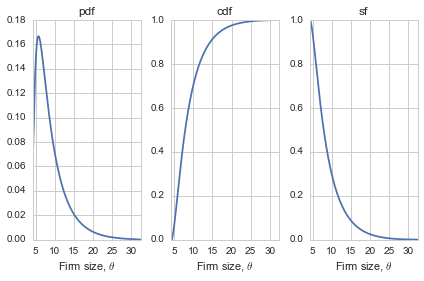

In [66]:
fig, axes = plt.subplots(1, 3)
theta_pdf = viz.compute_pdf('theta', normalize=True)
theta_pdf.plot(ax=axes[0])
axes[0].set_xlabel(r'Firm size, $\theta$')
axes[0].set_title(r'pdf')

theta_cdf = viz.compute_cdf(theta_pdf)
theta_cdf.plot(ax=axes[1])
axes[1].set_title(r'cdf')
axes[1].set_xlabel(r'Firm size, $\theta$')

theta_sf = viz.compute_sf(theta_cdf)
theta_sf.plot(ax=axes[2])
axes[2].set_title(r'sf')
axes[2].set_xlabel(r'Firm size, $\theta$')

plt.tight_layout()
plt.show()

## Distributions of factor payments

Can plot the distributions of average factor payments...

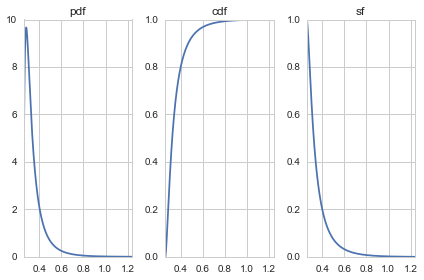

In [67]:
fig, axes = plt.subplots(1, 3)
factor_payment_1_pdf = viz.compute_pdf('factor_payment_1', normalize=True)
factor_payment_1_pdf.plot(ax=axes[0])
axes[0].set_title(r'pdf')

factor_payment_1_cdf = viz.compute_cdf(factor_payment_1_pdf)
factor_payment_1_cdf.plot(ax=axes[1])
axes[1].set_title(r'cdf')

factor_payment_1_sf = viz.compute_sf(factor_payment_1_cdf)
factor_payment_1_sf.plot(ax=axes[2])
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()

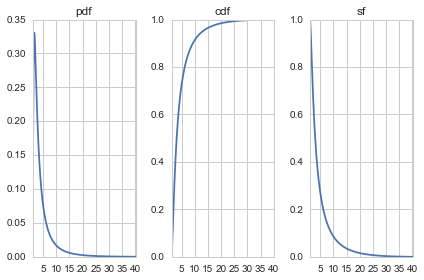

In [68]:
fig, axes = plt.subplots(1, 3)
factor_payment_2_pdf = viz.compute_pdf('factor_payment_2', normalize=True)
factor_payment_2_pdf.plot(ax=axes[0])
axes[0].set_title(r'pdf')

factor_payment_2_cdf = viz.compute_cdf(factor_payment_2_pdf)
factor_payment_2_cdf.plot(ax=axes[1])
axes[1].set_title(r'cdf')

factor_payment_2_sf = viz.compute_sf(factor_payment_2_cdf)
factor_payment_2_sf.plot(ax=axes[2])
axes[2].set_title(r'sf')

plt.tight_layout()
plt.show()

## Widget

In [69]:
from IPython.html import widgets

In [70]:
def interactive_plot(viz, omega_A=0.25, omega_B=0.5, sigma_A=0.5, sigma_B=1.0,
                     loc1=1.0, mu1=0.0, sigma1=1.0, loc2=1.0, mu2=0.0, sigma2=1.0):
    # update new parameters as needed
    new_F_params = {'omega_A': omega_A, 'omega_B': omega_B,
                    'sigma_A': sigma_A, 'sigma_B': sigma_B}
    viz.solver.problem.F_params = new_F_params
    
    new_input1_params = {'loc1': loc1, 'mu1': mu1, 'sigma1': sigma1}
    viz.solver.problem.input1.params = new_input1_params
    
    new_input2_params = {'loc2': loc2, 'mu2': mu2, 'sigma2': sigma2}
    viz.solver.problem.input2.params = new_input2_params
    
    # solve the model using a hotstart initial guess
    domain = [viz.solver.problem.input1.lower, viz.solver.problem.input1.upper]
    initial_coefs = viz.solver._coefs_array_to_dict(viz.solver.result.x, viz.solver.degrees)
    viz.solver.solve(kind="Chebyshev",
                     coefs_dict=initial_coefs,
                     domain=domain,
                     method='hybr')
    
    if viz.solver.result.success:
        viz._Visualizer__solution = None  # should not need to access this!
        viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
        viz.solution[['mu', 'theta']].plot(subplots=True)
        viz.normalized_residuals[['mu', 'theta']].plot(logy=True)
    else:
        print("Foobar!")

In [71]:
viz_widget = widgets.fixed(viz)

# widgets for the model parameters
eps = 1e-2
omega_A_widget = widgets.FloatSlider(value=0.25, min=eps, max=1-eps, step=eps,
                                     description=r"$\omega_A$")
sigma_A_widget = widgets.FloatSlider(value=0.5, min=eps, max=1-eps, step=eps,
                                     description=r"$\sigma_A$")
omega_B_widget = widgets.FloatSlider(value=0.5, min=eps, max=1-eps, step=eps,
                                     description=r"$\omega_B$")
sigma_B_widget = widgets.fixed(1.0)

# widgets for input distributions
loc_widget = widgets.fixed(1.0)
mu_1_widget = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=eps,
                                  description=r"$\mu_1$")
mu_2_widget = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=eps,
                                  description=r"$\mu_2$")
sigma_1_widget = widgets.FloatSlider(value=1.0, min=eps, max=2-eps, step=eps,
                                     description=r"$\sigma_1$")
sigma_2_widget = widgets.FloatSlider(value=1.0, min=eps, max=2-eps, step=eps,
                                     description=r"$\sigma_2$")


<function __main__.interactive_plot>

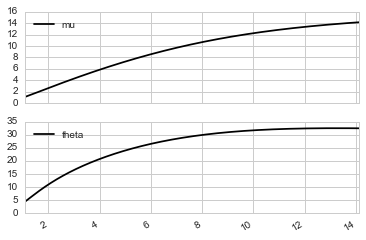

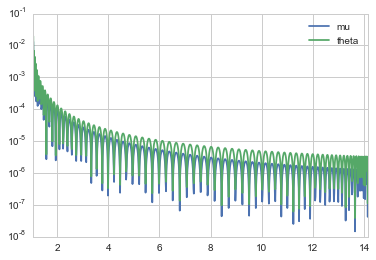

In [72]:
widgets.interact(interactive_plot, viz=viz_widget, omega_A=omega_A_widget,
                 sigma_A=sigma_A_widget, omega_B=omega_B_widget,
                 sigma_B=sigma_B_widget, sigma1=sigma_1_widget,
                 loc1=loc_widget, mu1 = mu_1_widget, 
                 loc2=loc_widget, sigma2=sigma_2_widget, mu2 = mu_2_widget)

In [33]:
# widget is changing the parameters of the underlying solver
solver.result.x

array([  8.90568813e+00,   6.50304514e+00,  -1.34672823e+00,
         4.28680104e-02,   4.77357817e-02,  -1.16819661e-02,
         2.42768746e-03,  -2.37437996e-03,   2.10810240e-03,
        -1.40176909e-03,   7.99162058e-04,  -3.80275138e-04,
         9.64930130e-05,   9.20733908e-05,  -2.11980720e-04,
         2.83286219e-04,  -3.21237323e-04,   3.36934880e-04,
        -3.38214224e-04,   3.30504837e-04,  -3.17512949e-04,
         3.01729493e-04,  -2.84799791e-04,   2.67787975e-04,
        -2.51363021e-04,   2.35927790e-04,  -2.21707416e-04,
         2.08809016e-04,  -1.97261326e-04,   1.87040266e-04,
        -1.78084533e-04,   1.70303868e-04,  -1.63581505e-04,
         1.57771621e-04,  -1.52692795e-04,   1.48115337e-04,
        -1.43718237e-04,   1.38974317e-04,  -1.33162529e-04,
         1.26395135e-04,  -6.07009143e-05,   2.41292593e+00,
         1.26940051e+00,  -5.48938116e-01,   1.31155224e-01,
        -2.84148111e-02,   8.73652285e-03,  -2.25182023e-03,
        -5.50594141e-04,